## XGBoostで学習と精度を確認する
- 年次ホールドアウト + StratifiedKFold（TF‑IDFはfold内fit, XGBoost）
- 直近 TEST_LAST_N 年を最終テストとして完全にホールドアウト
- それ以前のデータのみで StratifiedKFold を実施（情報リーク防止のため TF‑IDF は fold学習データでfit）
- OOF で 閾値最適化（macro_f1 または balanced_accuracy）


In [883]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 6
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "project_start_year"   # 年度列（数値化可能であること）
THRESHOLD = 100  # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 5  # 例: 直近5年をテスト

# TF-IDF
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 3
TFIDF_NGRAM = (1, 2)
# テキストベクトル化の方式を切替
# - 'char': 日本語向けに手軽な文字n-gram（デフォルト）
# - 'word': 形態素解析（fugashi）で単語n-gram
TEXT_TOKENIZER = 'char'  # 'word' も選択可
CHAR_NGRAM = (2, 4)      # analyzer='char_wb' 時の ngram_range
WORD_NGRAM = (1, 1)      # analyzer='word'（形態素）の ngram_range

# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

# XGBoost のデフォルト設定
XGB_PARAMS = dict(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    use_label_encoder=False,
)


In [884]:
import pandas as pd
df = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df.columns


Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

In [885]:
# 分布の確認
all_records = len(df)
print(f'all records {all_records}')

true = len(df[df[LABEL_BINARY_COL] == 1])
print(f'flg true records {true}')

print(f'flg false records {all_records - true}')


all records 2227
flg true records 1650
flg false records 577


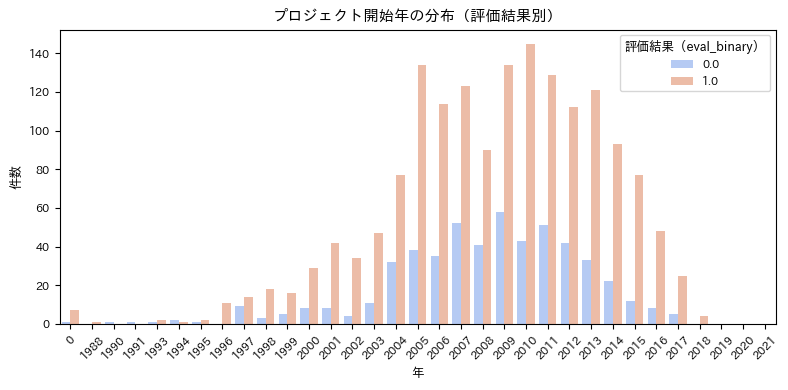

In [886]:
plt.figure(figsize=(8, 4))
sns.countplot(
    data=df,
    x=YEAR_COL,
    hue=LABEL_BINARY_COL,
    palette="coolwarm"
)
plt.title("プロジェクト開始年の分布（評価結果別）", fontsize=11)
plt.xlabel("年", fontsize=9)
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()


In [887]:
# 利用するテキストの特徴量を生成
df['description'] = df['background'] + df['description']


In [888]:
import numpy as np
import pandas as pd
from typing import Optional, Callable
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)
import xgboost as xgb
from xgboost import XGBClassifier
from pathlib import Path

def build_struct_features(df: pd.DataFrame, TEXT_COL: str, LABEL_BINARY_COL: str, features: list):
    if TEXT_COL not in df.columns:
        raise ValueError(f'テキスト列 {TEXT_COL} が見つかりません。')
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f'featuresに指定した列が見つかりません: {missing}')
    df2 = df.copy()
    df2[TEXT_COL] = df2[TEXT_COL].fillna("")
    use_cols = features + [LABEL_BINARY_COL, YEAR_COL]
    df_cln = df2.dropna(subset=use_cols).copy()
    if df_cln.empty:
        raise ValueError('欠損除外でデータが空になりました。列名や欠損を確認してください。')
    X_struct = df_cln[features].copy()
    y = df_cln[LABEL_BINARY_COL].astype(int)
    cat_cols = X_struct.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_struct.columns if c not in cat_cols]
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = ohe.fit_transform(X_struct[cat_cols]) if cat_cols else np.empty((len(X_struct), 0))
    X_num = X_struct[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()
    texts = df_cln[TEXT_COL].to_numpy()
    return df_cln, texts, y, X_num, X_cat, num_cols, cat_cols

def _ja_tokenizer_or_none() -> Optional[Callable[[str], list]]:
    try:
        from fugashi import Tagger  # type: ignore
    except Exception:
        return None
    tagger = Tagger()
    def tokenize_ja(text: str) -> list:
        return [w.surface for w in tagger(text)]
    return tokenize_ja

def create_vectorizer():
    if TEXT_TOKENIZER == 'word':
        tok = _ja_tokenizer_or_none()
        if tok is None:
            print('[WARN] fugashi not available. Falling back to char n-gram.')
        else:
            return TfidfVectorizer(
                tokenizer=tok,
                token_pattern=None,
                analyzer='word',
                ngram_range=WORD_NGRAM,
                min_df=TFIDF_MIN_DF,
                max_features=TFIDF_MAX_FEATURES,
            )
    return TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=CHAR_NGRAM,
        min_df=TFIDF_MIN_DF,
        max_features=TFIDF_MAX_FEATURES,
    )

def year_holdout_indices(df_cln: pd.DataFrame, YEAR_COL: str, last_n: int = 2):
    if YEAR_COL not in df_cln.columns:
        raise ValueError(f'YEAR_COL {YEAR_COL} が見つかりません。')
    years = pd.to_numeric(df_cln[YEAR_COL], errors="coerce")
    if years.isna().any():
        raise ValueError(f'YEAR_COL {YEAR_COL} に非数値/NaNがあります。')
    max_year = int(years.max())
    cut_years = list(range(max_year - last_n + 1, max_year + 1))
    test_mask = years.isin(cut_years)
    train_mask = ~test_mask
    train_idx = np.where(train_mask.values)[0]
    test_idx = np.where(test_mask.values)[0]
    return train_idx, test_idx, cut_years

def find_best_threshold(y_true, proba, objective="macro_f1"):
    qs = np.unique(np.quantile(proba, np.linspace(0.01, 0.99, 199)))
    ls = np.linspace(0.01, 0.99, 199)
    grid = np.unique(np.concatenate([qs, ls]))
    best_t, best_score = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        if objective == "macro_f1":
            score = f1_score(y_true, pred, average="macro", zero_division=0)
        elif objective == "balanced_accuracy":
            score = balanced_accuracy_score(y_true, pred)
        else:
            raise ValueError("objective must be 'macro_f1' or 'balanced_accuracy'")
        if score > best_score:
            best_score, best_t = score, t
    return float(best_t), float(best_score)


In [889]:
ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
    '分野'
]
df = pd.get_dummies(df, columns=ohe_col)


In [890]:
# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
]

# one-hot列のパターンをまとめて追加する場合はここで拡張してOK
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
region_columns = [c for c in df.columns if c.startswith('region_detail')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]

features = features + country_columns + type_columns + sector_columns + region_columns

In [ ]:
import xgboost as xgb
import inspect

# df が必要です（CSV読込または既存変数）
assert 'df' in globals(), '事前に df を用意してください（CSVから読むか、メモリ上にdfがある状態）。'

# 構造化＋テキストの前処理
df_cln, texts, y, X_num, X_cat, _, _ = build_struct_features(df, TEXT_COL, LABEL_BINARY_COL, features)

# 年次ホールドアウト
train_idx, test_idx, years_test = year_holdout_indices(df_cln, YEAR_COL, last_n=TEST_LAST_N)
if len(test_idx) == 0:
    raise ValueError('テストセットが空です。YEAR_COL/TEST_LAST_Nを確認してください。')

X_struct_all = np.hstack([X_num, X_cat])
X_train_struct = X_struct_all[train_idx]
X_test_struct = X_struct_all[test_idx]
X_train_text_raw = texts[train_idx]
X_test_text_raw = texts[test_idx]
y_train = y.iloc[train_idx].to_numpy()
y_test = y.iloc[test_idx].to_numpy()

print('=== Year-based split summary ===')
print(f'Years TEST: {years_test}')
print(f'Train size={len(train_idx)}, Test size={len(test_idx)}')
print(f'Train pos={int((y_train==1).sum())}, neg={int((y_train==0).sum())}')
print(f'Test  pos={int((y_test==1).sum())},  neg={int((y_test==0).sum())}')

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

oof_proba = np.zeros(len(y_train), dtype=float)
test_proba_folds = []
fold_rows = []

for fold, (tr_local, va_local) in enumerate(kf.split(X_train_struct, y_train), start=1):
    print(f'========== Fold {fold}/{N_SPLITS} ==========')
    X_tr_struct = X_train_struct[tr_local]
    X_va_struct = X_train_struct[va_local]
    y_tr = y_train[tr_local]
    y_va = y_train[va_local]

    vec = create_vectorizer()
    X_tr_text = vec.fit_transform(X_train_text_raw[tr_local])
    X_va_text = vec.transform(X_train_text_raw[va_local])
    X_te_text = vec.transform(X_test_text_raw)

    X_tr = np.hstack([X_tr_struct, X_tr_text.toarray()])
    X_va = np.hstack([X_va_struct, X_va_text.toarray()])
    X_te = np.hstack([X_test_struct, X_te_text.toarray()])

    model = XGBClassifier(**XGB_PARAMS)

    # バージョンに応じてfitの引数を切り替える
    fit_sig = inspect.signature(model.fit)
    supports_callbacks = "callbacks" in fit_sig.parameters
    supports_es_rounds = "early_stopping_rounds" in fit_sig.parameters

    fit_kwargs = dict(
        eval_set=[(X_va, y_va)],
        verbose=False,
        # 不均衡なら評価指標は AUC-PR 推奨（任意）
        eval_metric="aucpr",
    )

    if supports_callbacks:
        # 新しめのxgboost
        try:
            from xgboost.callback import EarlyStopping
            fit_kwargs["callbacks"] = [EarlyStopping(rounds=100, save_best=True)]
        except Exception:
            # もしcallback import不可なら、後段でes_roundsにフォールバック
            if supports_es_rounds:
                fit_kwargs["early_stopping_rounds"] = 100
    else:
        # 古めのxgboost
        if supports_es_rounds:
            fit_kwargs["early_stopping_rounds"] = 100

    model.fit(X_tr, y_tr, **fit_kwargs)

    va_proba = model.predict_proba(X_va)[:, 1]
    oof_proba[va_local] = va_proba

    auc = roc_auc_score(y_va, va_proba)
    va_pred05 = (va_proba >= 0.5).astype(int)
    f1_05 = f1_score(y_va, va_pred05, average='macro', zero_division=0)
    bacc_05 = balanced_accuracy_score(y_va, va_pred05)
    fold_rows.append({'fold': fold, 'AUC': auc, 'MacroF1@0.5': f1_05, 'BalAcc@0.5': bacc_05})

    test_proba = model.predict_proba(X_te)[:, 1]
    test_proba_folds.append(test_proba)

import pandas as pd
cv_df = pd.DataFrame(fold_rows)
print('[CV metrics @0.5]')
print(cv_df)
print('Mean ± Std')
print(cv_df[['AUC', 'MacroF1@0.5', 'BalAcc@0.5']].agg(['mean', 'std']))


=== Year-based split summary ===
Years TEST: [2014, 2015, 2016, 2017, 2018]
Train size=1666, Test size=291
Train pos=1260, neg=406
Test  pos=244,  neg=47
========== Fold 1/6 ==========


In [ ]:
# OOF AUC（閾値非依存の参照値）
oof_auc = roc_auc_score(y_train, oof_proba)
print(f'OOF AUC: {oof_auc:.4f}')

# テスト確率はfoldモデルの平均
test_proba_mean = np.mean(np.column_stack(test_proba_folds), axis=1)

# 閾値最適化
t_opt, score_opt = find_best_threshold(y_train, oof_proba, objective=THRESH_OBJECTIVE)
print(f'Best threshold by {THRESH_OBJECTIVE}: t={t_opt:.3f}, score={score_opt:.4f}')

y_test_pred = (test_proba_mean >= t_opt).astype(int)
print('[Test report with optimized threshold]')
print(f'Threshold used: {t_opt:.3f}')
print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0.0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0.0
bal_acc_test = (recall_0 + recall_1) / 2
macro_f1_test = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print('Confusion Matrix [rows=true, cols=pred] (labels: 0,1):')
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Fail', 'Pred Success'],
            yticklabels=['Actual Fail', 'Actual Success'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix on Test Data')
plt.show()

print(f'Test Balanced Accuracy: {bal_acc_test:.4f}')
print(f'Test Macro F1: {macro_f1_test:.4f}')


In [ ]:
from pathlib import Path
import numpy as np
import json

output_dir = Path('model_outputs_xgb_year_holdout')
output_dir.mkdir(exist_ok=True, parents=True)

cv_df.to_csv(output_dir / 'cv_metrics.csv', index=False)
np.save(output_dir / 'oof_proba.npy', oof_proba)
np.save(output_dir / 'test_proba.npy', np.array(test_proba_folds, dtype=float))
with open(output_dir / 'settings.json', 'w') as f:
    json.dump({
        'RANDOM_SEED': RANDOM_SEED,
        'N_SPLITS': N_SPLITS,
        'TEXT_COL': TEXT_COL,
        'LABEL_BINARY_COL': LABEL_BINARY_COL,
        'YEAR_COL': YEAR_COL,
        'TEST_LAST_N': TEST_LAST_N,
        'TFIDF_MAX_FEATURES': TFIDF_MAX_FEATURES,
        'TFIDF_MIN_DF': TFIDF_MIN_DF,
        'TFIDF_NGRAM': TFIDF_NGRAM,
        'XGB_PARAMS': XGB_PARAMS,
        'THRESH_OBJECTIVE': THRESH_OBJECTIVE
    }, f, indent=2, ensure_ascii=False)

print(f'Saved metrics and arrays to: {output_dir.resolve()}')


In [ ]:
TFIDF_MAX_FEATURES = 1000
print('TFIDF_MAX_FEATURES set to', TFIDF_MAX_FEATURES)


In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from pathlib import Path

required_vars = ['df_cln', 'features', 'train_idx', 'test_idx', 'TEXT_COL', 'YEAR_COL', 'LABEL_BINARY_COL', 'XGB_PARAMS']
for v in required_vars:
    assert v in globals(), f'変数 {v} が見つかりません。上のセルを順に実行してください。'

df_train = df_cln.iloc[train_idx].copy()
df_test = df_cln.iloc[test_idx].copy()

y_train_full = df_train[LABEL_BINARY_COL].astype(int).to_numpy()
y_test_full = df_test[LABEL_BINARY_COL].astype(int).to_numpy()

X_struct_train_df = df_train[features].copy()
X_struct_test_df = df_test[features].copy()

cat_cols = X_struct_train_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in X_struct_train_df.columns if c not in cat_cols]

ohe = OneHotEncoder(handle_unknown='ignore')
X_cat_train = ohe.fit_transform(X_struct_train_df[cat_cols]) if cat_cols else np.empty((len(X_struct_train_df), 0))
X_cat_test = ohe.transform(X_struct_test_df[cat_cols]) if cat_cols else np.empty((len(X_struct_test_df), 0))
cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []

X_num_train = X_struct_train_df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).to_numpy()
X_num_test = X_struct_test_df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).to_numpy()
num_feature_names = list(num_cols)

vec = create_vectorizer()
X_text_train = vec.fit_transform(df_train[TEXT_COL].fillna('').to_numpy())
X_text_test = vec.transform(df_test[TEXT_COL].fillna('').to_numpy())
text_feature_names = [f'tfidf::{t}' for t in vec.get_feature_names_out()]

X_train_full = np.hstack([X_num_train, X_cat_train, X_text_train.toarray()])
X_test_full = np.hstack([X_num_test, X_cat_test, X_text_test.toarray()])
feature_names = num_feature_names + cat_feature_names + text_feature_names

print(f'X_train_full shape: {X_train_full.shape}, features: {len(feature_names)}')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
tr_idx, va_idx = next(sss.split(X_train_full, y_train_full))
X_tr, X_va = X_train_full[tr_idx], X_train_full[va_idx]
y_tr, y_va = y_train_full[tr_idx], y_train_full[va_idx]

model = XGBClassifier(**XGB_PARAMS)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_va, y_va)],
    verbose=False,
    early_stopping_rounds=100,
)

n_sample = min(400, X_train_full.shape[0])
rng = np.random.default_rng(42)
idx_sample = rng.choice(np.arange(X_train_full.shape[0]), size=n_sample, replace=False)
X_shap = X_train_full[idx_sample]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

plt.figure()
shap.summary_plot(sv, X_shap, feature_names=feature_names, max_display=50, show=True)

mean_abs_shap = np.mean(np.abs(sv), axis=0)
imp_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs_shap}).sort_values('mean_abs_shap', ascending=False)
out = Path('model_outputs_xgb_year_holdout')
out.mkdir(exist_ok=True, parents=True)
imp_df.to_csv(out / 'shap_importance_top.csv', index=False)
print('Saved:', out / 'shap_importance_top.csv', '(top features by mean |SHAP|)')

topn = 30
top_df = imp_df.head(topn).iloc[::-1]
plt.figure()
plt.barh(top_df['feature'], top_df['mean_abs_shap'])
plt.title(f'Mean |SHAP| Top {topn}')
plt.xlabel('mean(|SHAP|)')
plt.tight_layout()
plt.show()


In [ ]:
features


In [ ]:
# 予備セル
